# Battle of Neighborhoods - Coursera Capstone Project

In this project I will try to compare neighborhoods in New York City and Toronto to see whether there are similarities and generate a list of neighborhoods in these two cities which are alike.

This notebook will contain:
- Data obtaining and cleaning
- Exploratory analysis
- Modeling

## 1. Data obtaining and cleaning

Let's start with downloading all the required libraries for the project.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import urllib
from urllib.request import urlopen # to read and parse web pages

from bs4 import BeautifulSoup # to conver the html code into readable form

import ssl

import requests

import matplotlib.pyplot as plt

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2019.3.9           |           py36_0         149 KB  conda-forge
    conda-4.6.10               |           py36_0         899 KB  conda-forge
    openssl-1.1.1b             |       h14c3975_1         4.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following packages will be UPDATED:

  ca-certificates                     2018.11.29-ha4d7672_0 --> 2019.3.9-hecc5488_0
  certifi                              2018.11.29-py36_1000 --> 2019.3.9-py36_0
  conda                                        4.6.4-py36_0 --> 4.6

First we will obtain data for New York City. I decided to limit my analysis by Manhattan only as it was easier to obtain publicly available data for the project. I used BeautifulSoup library to parse the webpage and obtain all the required information from it.

In [2]:
url = 'http://www.city-data.com/nbmaps/neigh-New-York-New-York.html#N16'

#to avoid error on ssl certificate
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

#open and parse the url
html = urllib.request.urlopen(url, context=ctx).read()
soup = BeautifulSoup(html,'html.parser')

#find "div" tags in the parsed html object.
tags = soup.findAll("div", attrs={'class':'neighborhood'})

In [3]:
#create a pandas dataframe with necessary columns and populate data from html object into the dataframe
count = 0
manhattan_census = pd.DataFrame(columns = ['Neighborhood','Area','Population','Household Income'])
for tag in tags:
    row = []
    neighborhood = tag.find("span", attrs={'class':'street-name'}).text
    row.append(neighborhood)
    for sec in tag.findAll('b'):
        if sec.text == 'Area:':
            area = sec.next_sibling
            row.append(area)
        if sec.text == 'Population:':
            population = sec.next_sibling
            row.append(population)
        if sec.text == 'Median household income in 2016: ':
            income = tag.findAll('table')[1].p.next_sibling
            row.append(income)
    try:
        manhattan_census.loc[count] = row
    except:
        continue
    count = count+1

manhattan_census.head()

,Neighborhood,Area,Population,Household Income
0,Battery Park City,0.207,"9,552","$126,771"
1,Bellevue,0.139,"7,060","$99,135"
2,Bowery,0.039,"2,106","$77,702"
3,Central Park,1.372,110,"$125,329"
4,Chelsea,0.774,"47,325","$116,160"


After inspecting the obtained data I have identified one erroneous row which I decided to remove.

In [4]:
manhattan_census.drop(25,inplace = True)
manhattan_census = manhattan_census.reset_index(drop = True)

In [5]:
manhattan_census.head()

,Neighborhood,Area,Population,Household Income
0,Battery Park City,0.207,"9,552","$126,771"
1,Bellevue,0.139,"7,060","$99,135"
2,Bowery,0.039,"2,106","$77,702"
3,Central Park,1.372,110,"$125,329"
4,Chelsea,0.774,"47,325","$116,160"


Since area information is given in square miles units I converted it into square miles units since Toronto data is all metric.

In [6]:
manhattan_census['Area'] = manhattan_census['Area'].astype(float)*2.58999

In [7]:
manhattan_census.head()

,Neighborhood,Area,Population,Household Income
0,Battery Park City,0.536128,"9,552","$126,771"
1,Bellevue,0.360009,"7,060","$99,135"
2,Bowery,0.101010,"2,106","$77,702"
3,Central Park,3.553466,110,"$125,329"
4,Chelsea,2.004652,"47,325","$116,160"


Also to conduct further analysis and to use the obtained information as variables in the model I need to convert the columns into float or integers.

In [8]:
population_nyc = manhattan_census['Population']

#this will remove the ',' from the values which will further enable me to convert the value to numeric type
pop_list_nyc = []
for pop in population_nyc:
    pop = pop.replace(',','')
    pop_list_nyc.append(pop)

#this actually converts the values into numeric type
pop_list_nyc = list(map(int, pop_list_nyc))

In [9]:
hh_income = manhattan_census['Household Income']

#this will remove the $ sign from the values
income_list = []
for income in hh_income:
    income = income[1:]
    income_list.append(income)

#this will remove the ',' from the values which will further enable me to convert the value to numeric type
inc_list_nyc = []
for income in income_list:
    inc = income.replace(',','')
    inc_list_nyc.append(inc)

#this actually converts the values into numeric type
inc_list_nyc = list(map(int, inc_list_nyc))

In [10]:
manhattan_census['Population'] = pop_list_nyc
manhattan_census['Household Income'] = inc_list_nyc
manhattan_census.head()

,Neighborhood,Area,Population,Household Income
0,Battery Park City,0.536128,9552,126771
1,Bellevue,0.360009,7060,99135
2,Bowery,0.101010,2106,77702
3,Central Park,3.553466,110,125329
4,Chelsea,2.004652,47325,116160


Then I did pretty much all these steps for Toronto data. Although, I found csv database for Toronto data, thus I just used pandas read_csv function to read it from the database and create a pandas data frame.

In [11]:
toronto = pd.read_csv('toronto_neighbourhood_profiles.csv')
toronto.drop(0, inplace = True)

In [12]:
area = list(toronto['Land area in square kilometres'])
income = list(toronto['  Average after-tax income of households in 2015 ($)'])
population = list(toronto['Population, 2016'])
nbh = list(toronto['Characteristic'])

In [13]:
toronto_census = pd.DataFrame()
toronto_census['Neighborhood'] = nbh
toronto_census['Area'] = area
toronto_census['Population'] = population
toronto_census['Household Income'] = income
toronto_census.head()

,Neighborhood,Area,Population,Household Income
0,Agincourt North,7.41,"29,113","427,037"
1,Agincourt South-Malvern West,7.83,"23,757","278,390"
2,Alderwood,4.95,"12,054","168,602"
3,Annex,2.81,"30,526","792,507"
4,Banbury-Don Mills,9.98,"27,695","493,486"


In [14]:
population_tor = toronto_census['Population']

#this will remove the ',' from the values which will further enable me to convert the value to numeric type
pop_list_tor = []
for pop in population_tor:
    pop = pop.replace(',','')
    pop_list_tor.append(pop)

#this actually converts the values into numeric type
pop_list_tor = list(map(int, pop_list_tor))

In [15]:
income_list_tor = toronto_census['Household Income']

inc_list_tor = []
for income in income_list_tor:
    inc = income.replace(',','')
    inc_list_tor.append(inc)

#this actually converts the values into numeric type
inc_list_tor = list(map(int, inc_list_tor))

In [16]:
toronto_census['Population'] = pop_list_tor
toronto_census['Household Income'] = inc_list_tor
toronto_census.head()

,Neighborhood,Area,Population,Household Income
0,Agincourt North,7.41,29113,427037
1,Agincourt South-Malvern West,7.83,23757,278390
2,Alderwood,4.95,12054,168602
3,Annex,2.81,30526,792507
4,Banbury-Don Mills,9.98,27695,493486


Since the absolute values of the columns might distort my analysis I normalized them as follows:

In [17]:
manhattan_census['Population normalized'] = manhattan_census['Population'] / manhattan_census['Population'].sum()
manhattan_census['Area normalized'] = manhattan_census['Area'] / manhattan_census['Area'].max()
manhattan_census['Household Income normalized'] = manhattan_census['Household Income'] / manhattan_census['Household Income'].max()
manhattan_census.head()

,Neighborhood,Area,Population,Household Income,Population normalized,Area normalized,Household Income normalized
0,Battery Park City,0.536128,9552,126771,0.002632,0.016757,0.644515
1,Bellevue,0.360009,7060,99135,0.001945,0.011252,0.504011
2,Bowery,0.101010,2106,77702,0.000580,0.003157,0.395044
3,Central Park,3.553466,110,125329,0.000030,0.111066,0.637184
4,Chelsea,2.004652,47325,116160,0.013040,0.062657,0.590568


In [18]:
toronto_census['Population normalized'] = toronto_census['Population'] / toronto_census['Population'].sum()
toronto_census['Area normalized'] = toronto_census['Area'] / toronto_census['Area'].max()
toronto_census['Household Income normalized'] = toronto_census['Household Income'] / toronto_census['Household Income'].max()
toronto_census.head()

,Neighborhood,Area,Population,Household Income,Population normalized,Area normalized,Household Income normalized
0,Agincourt North,7.41,29113,427037,0.010658,0.200867,0.302192
1,Agincourt South-Malvern West,7.83,23757,278390,0.008697,0.212253,0.197002
2,Alderwood,4.95,12054,168602,0.004413,0.134183,0.119311
3,Annex,2.81,30526,792507,0.011175,0.076172,0.560816
4,Banbury-Don Mills,9.98,27695,493486,0.010139,0.270534,0.349214


Then I obtained GPS coordinates for each neighborhood to use it in the further analysis to find venues within that neighborhood.

In [19]:
neighborhoods = manhattan_census['Neighborhood']
longitude = []
latitude = []
drop_list = []
for neighborhood in neighborhoods:
    address = '{}, Manhattan, New York City, NY'.format(neighborhood)
    
    geolocator = Nominatim(user_agent="neighborhood_ny_explorer")
    location = geolocator.geocode(address)
    try:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        drop_list.append(neighborhood)
        print('No coordinates')

No coordinates
No coordinates
No coordinates
No coordinates


In [20]:
neighborhoods_tor = toronto_census['Neighborhood']
longitude_tor = []
latitude_tor = []
drop_list_tor = []
for neighborhood in neighborhoods_tor:
    address = '{}, Toronto, ON'.format(neighborhood)
    
    geolocator_tor = Nominatim(user_agent="neighborhood_tor_explorer")
    location_tor = geolocator_tor.geocode(address)
    try:
        latitude_tor.append(location_tor.latitude)
        longitude_tor.append(location_tor.longitude)
    except:
        drop_list_tor.append(neighborhood)
        print('No coordinates')

No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates
No coordinates


In [21]:
manhattan_census.drop(np.where(manhattan_census['Neighborhood'].isin(drop_list))[0], inplace=True)
manhattan_census = manhattan_census.reset_index(drop=True)
manhattan_census.shape

(51, 7)

In [22]:
toronto_census.drop(np.where(toronto_census['Neighborhood'].isin(drop_list_tor))[0], inplace=True)
toronto_census = toronto_census.reset_index(drop=True)
toronto_census.shape

(104, 7)

Now that I have coordinates for each neighborhood in Manhattan and Toronto, I appended this information to the existing data frames.

In [23]:
manhattan_census['Latitude'] = latitude
manhattan_census['Longitude'] = longitude
manhattan_census['City'] = 'New York'
manhattan_census.head()

,Neighborhood,Area,Population,Household Income,Population normalized,Area normalized,Household Income normalized,Latitude,Longitude,City
0,Battery Park City,0.536128,9552,126771,0.002632,0.016757,0.644515,40.711017,-74.016937,New York
1,Bellevue,0.360009,7060,99135,0.001945,0.011252,0.504011,40.739267,-73.975360,New York
2,Bowery,0.101010,2106,77702,0.000580,0.003157,0.395044,40.717238,-73.995477,New York
3,Central Park,3.553466,110,125329,0.000030,0.111066,0.637184,40.783848,-73.964573,New York
4,Chelsea,2.004652,47325,116160,0.013040,0.062657,0.590568,40.746491,-74.001528,New York


In [24]:
toronto_census['Latitude'] = latitude_tor
toronto_census['Longitude'] = longitude_tor
toronto_census['City'] = 'Toronto'
toronto_census.head()

,Neighborhood,Area,Population,Household Income,Population normalized,Area normalized,Household Income normalized,Latitude,Longitude,City
0,Agincourt North,7.41,29113,427037,0.010658,0.200867,0.302192,43.808038,-79.266439,Toronto
1,Alderwood,4.95,12054,168602,0.004413,0.134183,0.119311,43.601717,-79.545232,Toronto
2,Annex,2.81,30526,792507,0.011175,0.076172,0.560816,43.670338,-79.407117,Toronto
3,Banbury-Don Mills,9.98,27695,493486,0.010139,0.270534,0.349214,43.734804,-79.357243,Toronto
4,Bathurst Manor,4.70,15873,251583,0.005811,0.127406,0.178032,43.763893,-79.456367,Toronto


Further I obtained all the required data regarding the venues in the neighborhoods from Foursquare.com.

In [25]:
CLIENT_ID = 'BO3PNCW5XOMTDWPU0E2YBQSMEVIX2WCFHX33ZKLJY3JMZG53' # your Foursquare ID
CLIENT_SECRET = 'XNIUIJXXXFQR0L1CJT4MNN3AVIVU5PUQU3FN2T0WCZXJFNXE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BO3PNCW5XOMTDWPU0E2YBQSMEVIX2WCFHX33ZKLJY3JMZG53
CLIENT_SECRET:XNIUIJXXXFQR0L1CJT4MNN3AVIVU5PUQU3FN2T0WCZXJFNXE


In [26]:
LIMIT = 150

I defined a function which would return me all the required information regarding this venues

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
                  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['icon']['prefix'].split('/',7)[-2]) for v in results])
    
    #create data frame and append the obtained information to this data frame
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Bigger Category']
        
    return(nearby_venues)

In [28]:
newyork_venues = getNearbyVenues(names=manhattan_census['Neighborhood'],
                                   latitudes=manhattan_census['Latitude'],
                                   longitudes=manhattan_census['Longitude']
                                  )

Battery Park City
Bellevue
Bowery
Central Park
Chelsea
Chinatown
City Hall
Civic Center
Downtown
East Harlem
East Village
Garment District
Gramercy Park
Gramercy-Flatiron
Greenwich Village
Hamilton Heights
Harlem
Hell's Kitchen
Inwood
Kips Bay
Lenox Hill
Little Italy
Lower East Side
Manhattan Valley
Manhattanville
Midtown
Midtown West
Morningside Heights
Murray Hill
NoHo
Nolita
Peter Cooper Village
Seaport
Soho
St. Nicholas Terrace
Stuyvesant Town
Sutton Place
Tribeca
Tudor City
Turtle Bay
Two Bridges
Union Square
Upper East Side
Upper West Side
Uptown
Wall Street
Washington Heights
West Side
West Village
World Trade Center
Yorkville


In [29]:
toronto_venues = getNearbyVenues(names=toronto_census['Neighborhood'],
                                   latitudes=toronto_census['Latitude'],
                                   longitudes=toronto_census['Longitude']
                                  )

Agincourt North
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bendale
Black Creek
Broadview North
Caledonia-Fairbank
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth East York
Don Valley Village
Dorset Park
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Humber Summit
Ionview
Islington-City Centre West
Junction Area
Keelesdale-Eglinton West
Kennedy Park
Kensington-Chinatown
Kingsway South
L'Amoreaux
Lansing-Westgate
Lawrence Park North
Lawrence Park South
Little Portugal
Long Branch
Malvern
Maple Leaf
Markland Wood
Milliken
Morningside
Moss Park
Mount Dennis
Mount Pleasant East
Mount Pleasant

Now that I extracted all the information about venues in each neighborhood in these two cities, let's check if it was extracted correctly

In [30]:
print(newyork_venues.shape)
newyork_venues.head()

(5100, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Bigger Category
0,Battery Park City,40.711017,-74.016937,Battery Park City Esplanade,40.711622,-74.017907,Park,parks_outdoors
1,Battery Park City,40.711017,-74.016937,Hudson Eats,40.712803,-74.016102,Food Court,shops
2,Battery Park City,40.711017,-74.016937,Equinox Brookfield Place,40.712704,-74.014995,Gym,building
3,Battery Park City,40.711017,-74.016937,"Waterfront Plaza, Brookfield Place",40.713241,-74.016241,Plaza,parks_outdoors
4,Battery Park City,40.711017,-74.016937,Liberty Park,40.710384,-74.013868,Park,parks_outdoors


In [31]:
print(toronto_venues.shape)
toronto_venues.head()

(6570, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Bigger Category
0,Agincourt North,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant,food
1,Agincourt North,43.808038,-79.266439,Samosa King - Embassy Restaurant,43.810152,-79.257316,Indian Restaurant,food
2,Agincourt North,43.808038,-79.266439,Fahmee Bakery & Jamaican Foods,43.810170,-79.280113,Caribbean Restaurant,food
3,Agincourt North,43.808038,-79.266439,Shoppers Drug Mart,43.808119,-79.269744,Pharmacy,shops
4,Agincourt North,43.808038,-79.266439,Grandeur Palace 華丽宮 (Grandeur Palace 華麗宮),43.797885,-79.270585,Chinese Restaurant,food


I can not use this information for my clustering as the data still needs some transformation, normalization and reshaping to make it convenient and clean for my analysis. This what I will be doing in the next several chunks of code.

First for New York City:

In [33]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Bigger Category','Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Neighborhood,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pub,Public Art,Ramen Restaurant,Recreation Center,Reservoir,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vi

In [34]:
newyork_grouped = newyork_onehot.groupby(['Neighborhood']).sum().reset_index()
print(newyork_grouped.shape)
newyork_grouped.head()

(51, 288)


,Neighborhood,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pub,Public Art,Ramen Restaurant,Recreation Center,Reservoir,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vi

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[9:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues_ny = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues_ny):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_ny = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_ny['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted_ny.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues_ny)

neighborhoods_venues_sorted_ny['City'] = manhattan_census['City']
neighborhoods_venues_sorted_ny['Area'] = manhattan_census['Area']
neighborhoods_venues_sorted_ny['Household Income'] = manhattan_census['Household Income']
neighborhoods_venues_sorted_ny['Population'] = manhattan_census['Population']   
neighborhoods_venues_sorted_ny['Latitude'] = manhattan_census['Latitude']
neighborhoods_venues_sorted_ny['Longitude'] = manhattan_census['Longitude']
neighborhoods_venues_sorted_ny = neighborhoods_venues_sorted_ny[['Neighborhood','City','Latitude', 'Longitude',
 'Area',
 'Population',
 'Household Income',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']]
neighborhoods_venues_sorted_ny.head()

,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,New York,40.711017,-74.016937,0.536128,9552,126771,Park,Coffee Shop,Hotel,Wine Shop,Gym / Fitness Center,Gym,Plaza,Bookstore,Dog Run,Pizza Place
1,Bellevue,New York,40.739267,-73.975360,0.360009,7060,99135,Gym / Fitness Center,Korean Restaurant,New American Restaurant,American Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Mexican Restaurant,Gym,Cocktail Bar,Japanese Restaurant
2,Bowery,New York,40.717238,-73.995477,0.101010,2106,77702,Coffee Shop,Cocktail Bar,Clothing Store,Asian Restaurant,Pizza Place,Mexican Restaurant,Boutique,Shoe Store,Bakery,Gourmet Shop
3,Central Park,New York,40.783848,-73.964573,3.553466,110,125329,Exhibit,Park,Italian Restaurant,Art Museum,Bookstore,Playground,American Restaurant,Bakery,Latin American Restaurant,Coffee Shop
4,Chelsea,New York,40.746491,-74.001528,2.004652,47325,116160,Art Gallery,Park,Yoga Studio,Coffee Shop,Lounge,Hotel,Tapas Restaurant,Seafood Restaurant,Salon / Barbershop,Gym / Fitness Center


In [37]:
def normalize(df):
    result = df.copy()
    columns = df.columns[1:]
    for feature_name in columns:
        sum_value = sum(list(df[feature_name]))
        result[feature_name] = df[feature_name] / sum_value
    return result

In [38]:
newyork_grouped = normalize(newyork_grouped)

In [39]:
newyork_final_table = newyork_grouped.merge(manhattan_census, on = 'Neighborhood')
newyork_final_table.head()

,Neighborhood,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pub,Public Art,Ramen Restaurant,Recreation Center,Reservoir,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vi

In [40]:
def reorder_columns(df):
    columns = df.columns
    first_columns = list([columns[0], columns[-1],columns[-9], columns[-5], columns[-8], columns[-6], columns[-7], columns[-4], columns[-3], columns[-2]])
    last_columns = list(columns[1:-9])
    new_order = first_columns + last_columns
    new_df = df[new_order]
    return(new_df)

In [41]:
newyork_final_table = reorder_columns(newyork_final_table)

In [42]:
newyork_final_table.drop(['Latitude','Longitude'],1, inplace = True)

In [53]:
print(newyork_final_table.shape)
newyork_final_table.head()

(51, 295)


,Neighborhood,City,Area,Area normalized,Population,Population normalized,Household Income,Household Income normalized,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pub,Public Art,Ramen Restaurant,Recreation Center,Reservoir,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Stationery Store,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,U

Then for Toronto

In [44]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Bigger Category','Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns1 = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns1]

toronto_onehot.head()

,Zoo Exhibit,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American R

In [45]:
toronto_grouped_raw = toronto_onehot.groupby(['Neighborhood']).sum().reset_index()
print(toronto_grouped_raw.shape)
zoo = toronto_grouped_raw['Zoo Exhibit']
toronto_grouped_rev = toronto_grouped_raw.drop('Zoo Exhibit',1)
toronto_grouped_rev['Zoo Exhibit'] = zoo
toronto_grouped = toronto_grouped_rev
toronto_grouped.head()

(104, 327)


,Neighborhood,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Sp

In [46]:
num_top_venues_tor = 10

columns = ['Neighborhood']
for ind in np.arange(num_top_venues_tor):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_tor = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_tor['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted_tor.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues_tor)

neighborhoods_venues_sorted_tor['City'] = toronto_census['City']
neighborhoods_venues_sorted_tor['Area'] = toronto_census['Area']
neighborhoods_venues_sorted_tor['Household Income'] = toronto_census['Household Income']
neighborhoods_venues_sorted_tor['Population'] = toronto_census['Population']
neighborhoods_venues_sorted_tor['Latitude'] = toronto_census['Latitude']
neighborhoods_venues_sorted_tor['Longitude'] = toronto_census['Longitude']
neighborhoods_venues_sorted_tor = neighborhoods_venues_sorted_tor[['Neighborhood','City', 'Latitude', 'Longitude',
 'Area',
 'Population',
 'Household Income',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']]
neighborhoods_venues_sorted_tor.head()

,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Toronto,43.808038,-79.266439,7.41,29113,427037,Indian Restaurant,Coffee Shop,Chinese Restaurant,Supermarket,Pharmacy,Discount Store,Park,Sandwich Place,Pizza Place,Bank
1,Alderwood,Toronto,43.601717,-79.545232,4.95,12054,168602,Pharmacy,Department Store,Discount Store,Burger Joint,Light Rail Station,Toy / Game Store,Grocery Store,Park,Coffee Shop,Café
2,Annex,Toronto,43.670338,-79.407117,2.81,30526,792507,Korean Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Café,Grocery Store,Park,Sushi Restaurant,French Restaurant,Gastropub
3,Banbury-Don Mills,Toronto,43.734804,-79.357243,9.98,27695,493486,Coffee Shop,Café,American Restaurant,Restaurant,Park,Liquor Store,Other Great Outdoors,Bike Shop,Clothing Store,Sushi Restaurant
4,Bathurst Manor,Toronto,43.763893,-79.456367,4.70,15873,251583,Coffee Shop,Grocery Store,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Gym,Mediterranean Restaurant,Men's Store,Fast Food Restaurant,Sports Bar


In [47]:
toronto_grouped = normalize(toronto_grouped)

In [48]:
toronto_final_table = toronto_grouped.merge(toronto_census, on = 'Neighborhood')
toronto_final_table.head()

,Neighborhood,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Sp

In [49]:
toronto_final_table = reorder_columns(toronto_final_table)

In [50]:
toronto_final_table.drop(['Latitude','Longitude'],1, inplace = True)

In [51]:
print(toronto_final_table.shape)
toronto_final_table.head()

(104, 334)


,Neighborhood,City,Area,Area normalized,Population,Population normalized,Household Income,Household Income normalized,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,

So I am done with cleaning and preparing data. Let's move to the exploratory analysis.

## 2. Exploratory analysis

To check whether the selected parameters are good for clustering we need to see if there is a similarity between two cities. First I decided to analyze the income levels in these cities.

In [54]:
manhattan_census.sort_values('Household Income', ascending = False).head()

,Neighborhood,Area,Population,Household Income,Population normalized,Area normalized,Household Income normalized,Latitude,Longitude,City
37,Tribeca,0.862467,17362,196692,0.004784,0.026957,1.000000,40.715380,-74.009306,New York
36,Sutton Place,0.031080,526,162101,0.000145,0.000971,0.824136,40.758037,-73.960182,New York
32,Seaport,0.233099,7450,154874,0.002053,0.007286,0.787393,40.705775,-74.002838,New York
41,Union Square,0.598288,9526,146245,0.002625,0.018700,0.743523,40.735909,-73.990163,New York
39,Turtle Bay,1.043766,24856,135360,0.006849,0.032624,0.688183,40.753467,-73.968866,New York


In [55]:
toronto_census.sort_values('Household Income', ascending = False).head()

,Neighborhood,Area,Population,Household Income,Population normalized,Area normalized,Household Income normalized,Latitude,Longitude,City
79,Rosedale-Moore Park,4.65,20923,1413132,0.007660,0.126050,1.000000,43.690388,-79.383297,Toronto
51,Lawrence Park South,3.24,15179,1216585,0.005557,0.087829,0.860914,43.729199,-79.403252,Toronto
47,Kingsway South,2.58,9271,900624,0.003394,0.069938,0.637325,43.647381,-79.511333,Toronto
42,Islington-City Centre West,16.21,43965,854623,0.016095,0.439414,0.604772,43.648795,-79.549000,Toronto
2,Annex,2.81,30526,792507,0.011175,0.076172,0.560816,43.670338,-79.407117,Toronto


(array([ 9.,  4., 13., 19.,  3.,  2.,  1.]),
 array([ 33893.,  57150.,  80407., 103664., 126921., 150178., 173435.,
        196692.]),
 <a list of 7 Patch objects>)

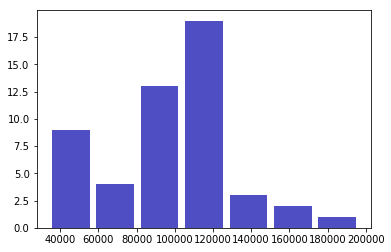

In [56]:
plt.hist(x=manhattan_census['Household Income'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

(array([25., 30., 20.,  8.,  8.,  3.,  3.,  3.,  1.,  1.,  0.,  0.,  1.,
         0.,  1.]),
 array([ 102259.        ,  189650.53333333,  277042.06666667,
         364433.6       ,  451825.13333333,  539216.66666667,
         626608.2       ,  713999.73333333,  801391.26666667,
         888782.8       ,  976174.33333333, 1063565.86666667,
        1150957.4       , 1238348.93333333, 1325740.46666667,
        1413132.        ]),
 <a list of 15 Patch objects>)

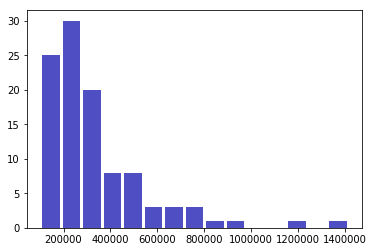

In [57]:
plt.hist(x=toronto_census['Household Income'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

As we can see two cities clearly differs in terms of income levels. There is clearly a bigger gap between poorest and richest neighborhoods in Toronto. While in New York City the income levels are more normally distributed.

The other thing that I wanted to observe was whether there is at least a similarity in terms of popular venues in these two cities.

In [62]:
newyork_grouped_other = newyork_onehot.groupby(['Neighborhood']).sum().reset_index()
venue_types = newyork_grouped_other.columns[9:]
venues_list = []
number_of_venues = []
for venue in venue_types:
    venues_list.append(venue)
    number_of_venues.append(newyork_grouped_other[venue].sum())
newyork_popular_venues = pd.DataFrame()
newyork_popular_venues['Venues'] = venues_list
newyork_popular_venues['Number of venues'] = number_of_venues
newyork_popular_venues.sort_values('Number of venues', ascending = False, inplace=True)
newyork_popular_venues.reset_index(drop = True, inplace = True)
newyork_popular_venues.head(10)

,Venues,Number of venues
0,Coffee Shop,174
1,Park,166
2,Italian Restaurant,154
3,Pizza Place,127
4,Theater,127
5,American Restaurant,124
6,Bakery,116
7,Gym,101
8,Hotel,93
9,Café,90


In [61]:
venue_types_tor = toronto_grouped_rev.columns[9:]
venues_list_tor = []
number_of_venues_tor = []
for venue in venue_types_tor:
    venues_list_tor.append(venue)
    number_of_venues_tor.append(toronto_grouped_rev[venue].sum())
toronto_popular_venues = pd.DataFrame()
toronto_popular_venues['Venues'] = venues_list_tor
toronto_popular_venues['Number of venues'] = number_of_venues_tor
toronto_popular_venues.sort_values('Number of venues', ascending = False, inplace=True)
toronto_popular_venues.reset_index(drop = True, inplace = True)
toronto_popular_venues.head(10)

,Venues,Number of venues
0,Coffee Shop,520
1,Café,262
2,Pizza Place,227
3,Park,225
4,Bakery,182
5,Italian Restaurant,179
6,Sandwich Place,165
7,Grocery Store,148
8,Restaurant,143
9,Fast Food Restaurant,141


Below is some additional analysis that I have conducted that helped me to decide to normalize the data.

In [89]:
print('New York median population per neighborhood:',newyork_final_table['Population normalized'].median())
print('Toronto median population per neighborhood:',toronto_final_table['Population normalized'].median())
print('New York median household income per neighborhood:',newyork_final_table['Household Income normalized'].median())
print('Toronto median household income per neighborhood:',toronto_final_table['Household Income normalized'].median())
print('New York median area of the neighborhood:',newyork_final_table['Area normalized'].median())
print('Toronto median area of the neighborhood:',toronto_final_table['Area normalized'].median())

New York median population per neighborhood: 0.006848905528033367
Toronto median population per neighborhood: 0.005973851677294861
New York median household income per neighborhood: 0.5248510361377179
Toronto median household income per neighborhood: 0.18703914425545526
New York median area of the neighborhood: 0.032461750182141993
Toronto median area of the neighborhood: 0.0802385470317159


As it is seen in the tables above 6 out of 5 categories in these two cities are the same, although there is some difference in ranking. But in general I believe this gives us some assurance that classification based on the venues in the city might provide reasonable results.

## 3. Modeling

After obtaining and cleaning all the data required for the analysis and confirming through exploratory data analysis that the obtained data might be used for the purpose of clustering neighborhoods, let's move on to the fun part and start getting some answers. However, first we need to combine two tables into a single one. But I will remove those columns which are not present for both cities.

In [63]:
tor=list(toronto_final_table.columns)
nyc=list(newyork_final_table.columns)

In [64]:
same_venues = []
for x in tor:
    for y in nyc:
        if x == y:
            same_venues.append(x)
len(same_venues)

225

In [65]:
toronto_final_table = toronto_final_table[same_venues]
newyork_final_table = newyork_final_table[same_venues]

In [66]:
combined_table = newyork_final_table.append(toronto_final_table)
combined_table.reset_index(drop = True, inplace=True)
combined_table.head()

,Neighborhood,City,Area,Area normalized,Population,Population normalized,Household Income,Household Income normalized,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Sake Bar,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Battery Park City,New York,0.536128,0.016757,9552,0.002632,126771,0.644515,0.012121,0.040441,0.0,0.012039,0.011450,0.046296,0.025922,0.027972,0.008065,0.2,0.0,0.0,0.000000,0.000000,0.000000,0.166667,0.083333,0.033333,0.008621,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.040816,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.090909,0.044444,0.0,0.000000,0.022222,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.045455,0.011628,0.028736,0.0,0.0,0.0,0.000000,0.0,0.000000,0.052632,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.055556,0.000000,0.0,0.0,0.076923,0.0,0.1,0.04,0.071429,0.0,0.0,0.0,0.00,0.000000,0.0,0.105263,0.045455,0.013699,0.0,0.0,0.066667,0.000000,0.0,0.2,0.000000,0.0,0.000000,0.000000,0.000000,0.016667,0.029703,0.036585,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.0,0.032258,0.047619,0.035088,0.000000,0.00000

In [67]:
combined_neighborhoods_venues_sorted = neighborhoods_venues_sorted_ny.append(neighborhoods_venues_sorted_tor)
combined_neighborhoods_venues_sorted.reset_index(drop = True, inplace=True)

combined_neighborhoods_venues_sorted.head()

,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,New York,40.711017,-74.016937,0.536128,9552,126771,Park,Coffee Shop,Hotel,Wine Shop,Gym / Fitness Center,Gym,Plaza,Bookstore,Dog Run,Pizza Place
1,Bellevue,New York,40.739267,-73.975360,0.360009,7060,99135,Gym / Fitness Center,Korean Restaurant,New American Restaurant,American Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Mexican Restaurant,Gym,Cocktail Bar,Japanese Restaurant
2,Bowery,New York,40.717238,-73.995477,0.101010,2106,77702,Coffee Shop,Cocktail Bar,Clothing Store,Asian Restaurant,Pizza Place,Mexican Restaurant,Boutique,Shoe Store,Bakery,Gourmet Shop
3,Central Park,New York,40.783848,-73.964573,3.553466,110,125329,Exhibit,Park,Italian Restaurant,Art Museum,Bookstore,Playground,American Restaurant,Bakery,Latin American Restaurant,Coffee Shop
4,Chelsea,New York,40.746491,-74.001528,2.004652,47325,116160,Art Gallery,Park,Yoga Studio,Coffee Shop,Lounge,Hotel,Tapas Restaurant,Seafood Restaurant,Salon / Barbershop,Gym / Fitness Center


In [68]:
venue_categories = list(combined_table.columns[16:])
venue_bigger_categories = list(combined_table.columns[8:16])
vc = venue_categories + ['Neighborhood', 'City','Area', 'Population', 'Household Income']
vbc = venue_bigger_categories + ['Neighborhood', 'City','Area', 'Population', 'Household Income']

I decided to use normalized values since as we have seen there are some differences in terms of absolute values and certain parameters, which make the clustering using absolute values erroneous.

As there are no labels in the dataset I decided to optimize the model for sum of squared distances to cluster centroids and elbow method to determine the optimal number of clusters to use.

Text(0, 0.5, 'Sum of squared distance')

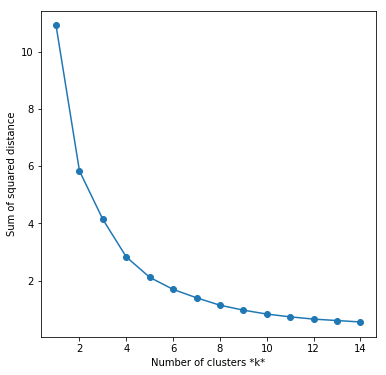

In [69]:
list_k = list(range(1, 15))
sse = []

for k in list_k:
    combined_clustering = combined_table.drop(vc, 1)
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(combined_clustering)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Based on the results obtained above I decided to use k = 5.

In [70]:
kclusters = 5

combined_clustering = combined_table.drop(vc, 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(combined_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 4, 0, 0, 4, 4, 4, 4, 1], dtype=int32)

After clustering neighborhoods I appended the column with labels to the combined table.

In [71]:
combined_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [72]:
combined_neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Battery Park City,New York,40.711017,-74.016937,0.536128,9552,126771,Park,Coffee Shop,Hotel,Wine Shop,Gym / Fitness Center,Gym,Plaza,Bookstore,Dog Run,Pizza Place
1,4,Bellevue,New York,40.739267,-73.975360,0.360009,7060,99135,Gym / Fitness Center,Korean Restaurant,New American Restaurant,American Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Mexican Restaurant,Gym,Cocktail Bar,Japanese Restaurant
2,4,Bowery,New York,40.717238,-73.995477,0.101010,2106,77702,Coffee Shop,Cocktail Bar,Clothing Store,Asian Restaurant,Pizza Place,Mexican Restaurant,Boutique,Shoe Store,Bakery,Gourmet Shop
3,0,Central Park,New York,40.783848,-73.964573,3.553466,110,125329,Exhibit,Park,Italian Restaurant,Art Museum,Bookstore,Playground,American Restaurant,Bakery,Latin American Restaurant,Coffee Shop
4,0,Chelsea,New York,40.746491,-74.001528,2.004652,47325,116160,Art Gallery,Park,Yoga Studio,Coffee Shop,Lounge,Hotel,Tapas Restaurant,Seafood Restaurant,Salon / Barbershop,Gym / Fitness Center


### Cluster 1

In [73]:
combined_neighborhoods_venues_sorted.loc[combined_neighborhoods_venues_sorted['Cluster Labels'] == 0].head()

,Cluster Labels,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Battery Park City,New York,40.711017,-74.016937,0.536128,9552,126771,Park,Coffee Shop,Hotel,Wine Shop,Gym / Fitness Center,Gym,Plaza,Bookstore,Dog Run,Pizza Place
3,0,Central Park,New York,40.783848,-73.964573,3.553466,110,125329,Exhibit,Park,Italian Restaurant,Art Museum,Bookstore,Playground,American Restaurant,Bakery,Latin American Restaurant,Coffee Shop
4,0,Chelsea,New York,40.746491,-74.001528,2.004652,47325,116160,Art Gallery,Park,Yoga Studio,Coffee Shop,Lounge,Hotel,Tapas Restaurant,Seafood Restaurant,Salon / Barbershop,Gym / Fitness Center
11,0,Garment District,New York,40.753694,-73.990517,0.525768,7539,109090,Theater,Coffee Shop,Hotel,Chinese Restaurant,Bakery,Gym / Fitness Center,Korean Restaurant,Italian Restaurant,Miscellaneous Shop,Gym
12,0,Gramercy Park,New York,40.737925,-73.985932,0.505048,12442,110745,New American Restaurant,American Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Gym,Cycle Studio,Japanese Restaurant,Mediterranean Restaurant,Gourmet Shop,Chinese Restaurant


### Cluster 2

In [74]:
combined_neighborhoods_venues_sorted.loc[combined_neighborhoods_venues_sorted['Cluster Labels'] == 1].head()

,Cluster Labels,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,1,East Harlem,New York,40.794722,-73.942500,3.799515,125763,39390,Mexican Restaurant,Bakery,Pizza Place,Café,Park,Cocktail Bar,Latin American Restaurant,Italian Restaurant,Deli / Bodega,Coffee Shop
15,1,Hamilton Heights,New York,40.824145,-73.950062,1.077436,47531,43673,Coffee Shop,Bar,Café,Park,Mexican Restaurant,Yoga Studio,Chinese Restaurant,Italian Restaurant,Caribbean Restaurant,American Restaurant
16,1,Harlem,New York,40.807879,-73.945415,7.624931,253065,41680,Southern / Soul Food Restaurant,Jazz Club,French Restaurant,Café,Grocery Store,Theater,Coffee Shop,Gym / Fitness Center,Seafood Restaurant,Pizza Place
18,1,Inwood,New York,40.869258,-73.920495,3.224538,58946,49131,Latin American Restaurant,Mexican Restaurant,Café,Park,Wine Bar,Deli / Bodega,Coffee Shop,Spanish Restaurant,Restaurant,Lounge
22,1,Lower East Side,New York,40.715936,-73.986806,1.289815,39083,51649,Italian Restaurant,Cocktail Bar,Ice Cream Shop,Deli / Bodega,Coffee Shop,Asian Restaurant,Wine Shop,Chinese Restaurant,Wine Bar,New American Restaurant


### Cluster 3

In [75]:
combined_neighborhoods_venues_sorted.loc[combined_neighborhoods_venues_sorted['Cluster Labels'] == 2].head()

,Cluster Labels,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,2,Washington Heights,New York,40.840198,-73.940221,4.485863,201590,45316,Park,Bakery,Latin American Restaurant,Bar,Deli / Bodega,Café,Italian Restaurant,Dog Run,Coffee Shop,Tapas Restaurant
97,2,Kensington-Chinatown,Toronto,43.654378,-79.398899,1.520000,17945,222404,Café,Bar,Coffee Shop,Restaurant,Sandwich Place,Bakery,Vegetarian / Vegan Restaurant,Mexican Restaurant,French Restaurant,Gaming Cafe
138,2,Stonegate-Queensway,Toronto,43.621950,-79.523499,7.830000,25051,516575,Fast Food Restaurant,Coffee Shop,Sandwich Place,Restaurant,BBQ Joint,Burger Joint,Japanese Restaurant,Italian Restaurant,Sporting Goods Shop,Bank


### Cluster 4

In [76]:
combined_neighborhoods_venues_sorted.loc[combined_neighborhoods_venues_sorted['Cluster Labels'] == 3].head()

,Cluster Labels,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,3,Uptown,New York,40.83375,-73.944794,31.994146,895135,77558,Park,Coffee Shop,Bar,Mexican Restaurant,Bakery,Latin American Restaurant,Café,Italian Restaurant,Yoga Studio,Caribbean Restaurant
131,3,Rouge,Toronto,43.80493,-79.165837,36.890000,46496,729154,Trail,Pizza Place,Park,Zoo Exhibit,Bus Station,Bakery,Discount Store,Hardware Store,Campground,Pharmacy


### Cluster 5

In [77]:
combined_neighborhoods_venues_sorted.loc[combined_neighborhoods_venues_sorted['Cluster Labels'] == 4].head()

,Cluster Labels,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,4,Bellevue,New York,40.739267,-73.975360,0.360009,7060,99135,Gym / Fitness Center,Korean Restaurant,New American Restaurant,American Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Mexican Restaurant,Gym,Cocktail Bar,Japanese Restaurant
2,4,Bowery,New York,40.717238,-73.995477,0.101010,2106,77702,Coffee Shop,Cocktail Bar,Clothing Store,Asian Restaurant,Pizza Place,Mexican Restaurant,Boutique,Shoe Store,Bakery,Gourmet Shop
5,4,Chinatown,New York,40.716491,-73.996250,0.212379,7596,68657,Coffee Shop,French Restaurant,Clothing Store,Asian Restaurant,Pizza Place,Italian Restaurant,Bakery,Cocktail Bar,Men's Store,Greek Restaurant
6,4,City Hall,New York,40.712565,-74.006847,0.492098,15800,100294,Park,Coffee Shop,French Restaurant,Café,American Restaurant,Gym,Hotel,Bakery,Spa,Asian Restaurant
7,4,Civic Center,New York,40.713679,-74.002404,2.059042,61896,104375,Bakery,Coffee Shop,French Restaurant,Hotel,Sandwich Place,Café,Chinese Restaurant,Women's Store,Wine Bar,Spa


let's plot it to the map now.

In [78]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
nyc_location = geolocator.geocode(address)
nyc_latitude = nyc_location.latitude
nyc_longitude = nyc_location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(nyc_latitude, nyc_longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [81]:
new_york = combined_neighborhoods_venues_sorted.loc[combined_neighborhoods_venues_sorted['City'] == 'New York']

In [82]:
# create map
nyc_clusters = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_york['Latitude'], new_york['Longitude'], new_york['Neighborhood'], new_york['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(nyc_clusters)
       
nyc_clusters

In [83]:
address = 'Toronto, ON'

geolocator_tor = Nominatim(user_agent="tor_explorer")
tor_location = geolocator_tor.geocode(address)
tor_latitude = tor_location.latitude
tor_longitude = tor_location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(tor_latitude, tor_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [84]:
toronto_city = combined_neighborhoods_venues_sorted.loc[combined_neighborhoods_venues_sorted['City'] == 'Toronto']
toronto_city.head()

,Cluster Labels,Neighborhood,City,Latitude,Longitude,Area,Population,Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,4,Agincourt North,Toronto,43.808038,-79.266439,7.41,29113,427037,Indian Restaurant,Coffee Shop,Chinese Restaurant,Supermarket,Pharmacy,Discount Store,Park,Sandwich Place,Pizza Place,Bank
52,1,Alderwood,Toronto,43.601717,-79.545232,4.95,12054,168602,Pharmacy,Department Store,Discount Store,Burger Joint,Light Rail Station,Toy / Game Store,Grocery Store,Park,Coffee Shop,Café
53,0,Annex,Toronto,43.670338,-79.407117,2.81,30526,792507,Korean Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Café,Grocery Store,Park,Sushi Restaurant,French Restaurant,Gastropub
54,4,Banbury-Don Mills,Toronto,43.734804,-79.357243,9.98,27695,493486,Coffee Shop,Café,American Restaurant,Restaurant,Park,Liquor Store,Other Great Outdoors,Bike Shop,Clothing Store,Sushi Restaurant
55,1,Bathurst Manor,Toronto,43.763893,-79.456367,4.70,15873,251583,Coffee Shop,Grocery Store,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Gym,Mediterranean Restaurant,Men's Store,Fast Food Restaurant,Sports Bar


In [85]:
# create map
tor_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_city['Latitude'], toronto_city['Longitude'], toronto_city['Neighborhood'], toronto_city['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tor_clusters)
       
tor_clusters

# Thank you for your interest in this project!